In [17]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline


# sys.path.append("/path/to/your/project")
from hockey.hockey_env import HockeyEnv_BasicOpponent, Mode, HockeyEnv

try:
    from models.ddpg.DDPG import DDPGAgent
    from models.ddpg.DDPGTrainer import DDPGTrainer
except ImportError:
    print("Could not import DDPG.")
    raise

In [18]:
# The single-agent wrapper environment is `HockeyEnv_BasicOpponent`.
# By default:
#   - It uses mode=Mode.NORMAL
#   - keep_mode=True
#   - An opponent with `weak_opponent=False` or True
#
# action_space of shape (4,) 
# suitable for a single-agent continuous control algorithms

env = HockeyEnv_BasicOpponent(
    mode=Mode.NORMAL,   # or Mode.TRAIN_SHOOTING, Mode.TRAIN_DEFENSE
    weak_opponent=True # whether the opponent is weaker or not
)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# For reference:
# - The observation space is Box(...) with shape (18,) if keep_mode=True.
# - The action space is Box(...) with shape (4,). 
#   The four actions: 
#       1) Force in x, 
#       2) Force in y, 
#       3) Torque (racket rotation),
#       4) Shoot command (0 or 1).

Observation space: Box(-inf, inf, (18,), float32)
Action space: Box(-1.0, 1.0, (4,), float32)


In [5]:
self_play_env = HockeyEnv(mode=Mode.NORMAL, keep_mode=True)
print("Observation space:", self_play_env.observation_space)
print("Action space:", self_play_env.action_space)

Observation space: Box(-inf, inf, (18,), float32)
Action space: Box(-1.0, 1.0, (8,), float32)


In [19]:
training_config = {
    "env_mode": Mode.NORMAL,
    "max_episodes": 10000,     
    "max_timesteps": 250,    
    "log_interval": 20,
    "save_interval": 1000,
    "render": False,         
    "train_iter": 32,       
    "seed": 42      
}

model_config = {
    "noise_scale": 0.1,                  
    "discount": 0.95,      
    "buffer_size": int(1e6),     
    "batch_size": 128,            
    "learning_rate_actor": 1e-4, 
    "learning_rate_critic": 1e-4,
    "hidden_sizes_actor": [256, 256],
    "hidden_sizes_critic": [256, 256],
    "update_target_every": 100,
    "use_target_net": True
}

experiment_path = "rl_experiments/experiments/HockeyEnv_DDPG_Test"

# Initialize trainer
trainer = DDPGTrainer(
    env_name="HockeyEnv",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None 
)


2025-01-29 19:22:05 [INFO] Logger initialized. Writing logs to rl_experiments/experiments/HockeyEnv_DDPG_Test/results/training/logs/DDPG_HockeyEnv_noise0.1_alr0.0001_clr0.0001_gamma0.95.log
2025-01-29 19:22:05 [INFO] Initialized random seeds to 42.


In [12]:
checkpoint_path = "DDPG_HockeyEnv_noise0.1_alr0.0001_clr0.0001_gamma0.95_checkpoint_ep18000.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# restore the agent's networks
trainer.agent.restore_state(checkpoint)

/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_4447/2494310159.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

In [5]:
## This is only experimental, not sure if the hypothesis is valid

final_metrics = trainer.train()

print("Training finished.")
print("Final metrics:", final_metrics)

2025-01-26 23:32:01 [INFO] Starting DDPG Training...
2025-01-26 23:32:01 [INFO] Environment: HockeyEnv, max_episodes=10000, max_timesteps=250, train_iter=32
2025-01-26 23:32:03 [INFO] Episode 20	Avg Length: 149.00	Avg Reward: -8.917
2025-01-26 23:32:05 [INFO] Episode 40	Avg Length: 161.05	Avg Reward: -9.821
2025-01-26 23:32:07 [INFO] Episode 60	Avg Length: 162.90	Avg Reward: -12.780
2025-01-26 23:32:10 [INFO] Episode 80	Avg Length: 142.25	Avg Reward: -7.654
2025-01-26 23:32:12 [INFO] Episode 100	Avg Length: 135.85	Avg Reward: -9.985
2025-01-26 23:32:14 [INFO] Episode 120	Avg Length: 143.60	Avg Reward: -9.728
2025-01-26 23:32:17 [INFO] Episode 140	Avg Length: 146.50	Avg Reward: -10.438
2025-01-26 23:32:19 [INFO] Episode 160	Avg Length: 164.05	Avg Reward: -8.222
2025-01-26 23:32:22 [INFO] Episode 180	Avg Length: 131.05	Avg Reward: -6.618
2025-01-26 23:32:25 [INFO] Episode 200	Avg Length: 125.65	Avg Reward: -9.051
2025-01-26 23:32:27 [INFO] Episode 220	Avg Length: 145.95	Avg Reward: -5.98

In [13]:
num_test_episodes = 100
cumulative_rewards = []
win_count = 0
for ep in range(num_test_episodes):
    obs, _ = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # set simple deterministic policy
        action = trainer.agent.act(obs, evaluate=True)  
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        env.render(mode="rgb_array")

        if done or trunc:
            break
    cumulative_rewards.append(episode_reward)
    if info["winner"] == 1:
        win_count += 1

env.close()

print("Average cumulative reward:", np.mean(cumulative_rewards))
print("Win rate:", win_count / num_test_episodes)



Average cumulative reward: 4.77432291487633
Win rate: 0.63


In [22]:
obs, reward, done, trunc, info = env.step(action)
print("Info:", info)

Info: {'winner': -1, 'reward_closeness_to_puck': -0.08897551981456746, 'reward_touch_puck': 0.0, 'reward_puck_direction': -0.002343505096435547}


In [9]:
# plot the cumulative rewards
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over Episodes")
plt.show()


/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_20009/4163330427.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [7]:
import imageio
import numpy as np

num_test_episodes = 50

for ep in range(num_test_episodes):
    frames = []
    obs, info = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # Act with no noise at test time
        action = trainer.agent.act(obs, evaluate=True)
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        # ---- Capture frame in rgb_array mode ----
        frame_rgb = env.render(mode='rgb_array')  
        frames.append(frame_rgb)

        if done or trunc:
            break

    env.close()
    print(f"Episode {ep} reward: {episode_reward}", end=" ")
    if info["winner"] == 1:
        print("Won")
    else:
        print("Lost")


    gif_path = f"gifs/ddpg_laserhockey_episode{ep}.gif"
    imageio.mimsave(gif_path, frames, fps=15)

Episode 0 reward: 8.936073446347653 Won
Episode 1 reward: -3.680941078652339 Lost
Episode 2 reward: 5.686836507339108 Won
Episode 3 reward: 7.939335089901141 Won
Episode 4 reward: -13.075863483696557 Lost
Episode 5 reward: 7.480006595146768 Won
Episode 6 reward: 5.309186441633347 Won
Episode 7 reward: 8.29429584536864 Won
Episode 8 reward: -13.295177250518417 Lost
Episode 9 reward: 9.459147403107348 Won
Episode 10 reward: -10.851535856125562 Lost
Episode 11 reward: 5.935956324338293 Won
Episode 12 reward: -12.028975591788955 Lost
Episode 13 reward: 8.241157593857107 Won
Episode 14 reward: -6.4154907420834535 Lost
Episode 15 reward: 9.301639333712199 Won
Episode 16 reward: 9.153512559753235 Won
Episode 17 reward: -5.145979633781056 Lost
Episode 18 reward: -4.552991209537665 Lost
Episode 19 reward: -4.069215832383605 Lost
Episode 20 reward: -11.359597980848859 Lost
Episode 21 reward: -13.188471066550333 Lost
Episode 22 reward: -11.488474307694617 Lost
Episode 23 reward: -2.22451216862485

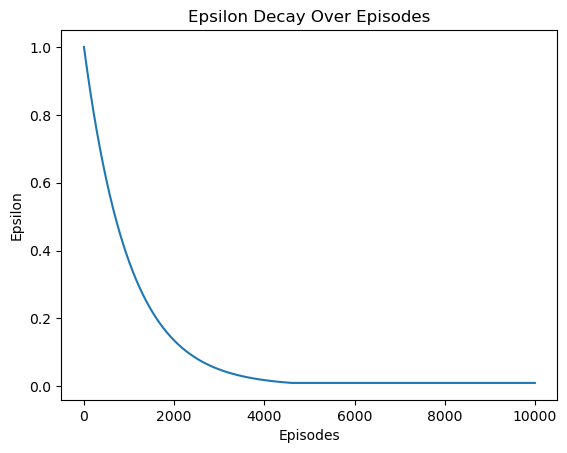

In [23]:
epsilon_start = 1.0  
epsilon_end = 0.01  
epsilon_decay = 0.999
max_episodes=10000
max_steps=500
episodes = np.arange(max_episodes)
epsilon_values = epsilon_start * (epsilon_decay ** episodes)
epsilon_values = np.maximum(epsilon_values, epsilon_end)

plt.plot(episodes, epsilon_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.show()

In [12]:

# 4) Save frames as GIF
gif_path = "ddpg_laserhockey_episode.gif"
imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
print(f"Saved GIF to {gif_path}")

Saved GIF to ddpg_laserhockey_episode.gif


## Further Training on Specialized curriculum

In [ ]:
def run_curriculum():
    # First we train Shooting
    trainer = DDPGTrainer(env_name="HockeyEnv",
                          training_config=training_config,
                          model_config=model_config,
                          experiment_path=experiment_path,
                          env_mode="train_shooting",
                          weak_opponent=True)
    trainer.train()  # => here we store final checkpoint
    
    # Then we train Defense
    trainer.env.close()
    trainer.env_mode = "train_defense"
    trainer.train()
    
    # Weak Opponent
    trainer.env.close()
    trainer.env_mode = "normal"
    trainer.weak_opponent = True
    trainer.train()
    
    # Normal Mode Strong Opponent
    trainer.env.close()
    trainer.weak_opponent = False
    trainer.train()

    # Maybe we can try self play with agent versions trained on the strong opponent


## Testing Self Play

In [14]:
training_config = {
    "env_mode": Mode.NORMAL,
    "max_episodes": 10000,     
    "max_timesteps": 250,    
    "log_interval": 20,
    "save_interval": 1000,
    "render": False,         
    "train_iter": 32,       
    "seed": 42      
}

model_config = {
    "noise_scale": 0.1,                  
    "discount": 0.95,      
    "buffer_size": int(1e6),     
    "batch_size": 128,            
    "learning_rate_actor": 1e-4, 
    "learning_rate_critic": 1e-4,
    "hidden_sizes_actor": [256, 256],
    "hidden_sizes_critic": [256, 256],
    "update_target_every": 100,
    "use_target_net": True
}

experiment_path = "rl_experiments/experiments/HockeyEnv_DDPG_SelfPlay"

# Initialize trainer
agent1_trainer = DDPGTrainer(
    env_name="HockeyEnv",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None 
)

# Initialize trainer
agent2_trainer = DDPGTrainer(
    env_name="HockeyEnv",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None 
)


2025-01-29 12:44:54 [INFO] Logger initialized. Writing logs to rl_experiments/experiments/HockeyEnv_DDPG_SelfPlay/results/training/logs/DDPG_HockeyEnv_noise0.1_alr0.0001_clr0.0001_gamma0.95.log
2025-01-29 12:44:54 [INFO] Initialized random seeds to 42.
2025-01-29 12:44:54 [INFO] Logger initialized. Writing logs to rl_experiments/experiments/HockeyEnv_DDPG_SelfPlay/results/training/logs/DDPG_HockeyEnv_noise0.1_alr0.0001_clr0.0001_gamma0.95.log
2025-01-29 12:44:54 [INFO] Initialized random seeds to 42.


In [15]:
checkpoint_path_agent1 = "DDPG_HockeyEnv_noise0.1_alr0.0001_clr0.0001_gamma0.95_checkpoint_ep18000.pth"
checkpoint_path_agent2 = "DDPG_HockeyEnv_noise0.1_alr0.0001_clr0.0001_gamma0.95_checkpoint_ep10000.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# restore the agent's networks
agent1_trainer.agent.restore_state(checkpoint)
agent2_trainer.agent.restore_state(checkpoint)

/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_4447/3004529923.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

In [16]:
import imageio
import numpy as np

num_test_episodes = 50
# 1) Initialize environment
env = HockeyEnv(keep_mode=True, mode="NORMAL")  # or TRAIN_SHOOTING, etc.

# 2) Load your two trained agents (DDPG #1 and DDPG #2)
agent1 = agent1_trainer.agent
agent2 = agent2_trainer.agent

# 3) Run self-play episodes
for episode in range(num_test_episodes):
    frames = []
    obs, info = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # (a) Observations for each agent
        obs_agent1 = obs  # The default obs is always from player1's perspective
        obs_agent2 = env.obs_agent_two()  # The environment provides a "mirrored" obs for player2
        
        # (b) Each agent selects an action
        act1 = agent1.act(obs_agent1, evaluate=True)  # shape = (4,) if keep_mode=True
        act2 = agent2.act(obs_agent2, evaluate=True)  # shape = (4,)

        # (c) Concatenate into one 8D action: first 4 for player1, second 4 for player2
        combined_act = np.hstack([act1, act2])  # shape = (8,)

        # (d) Step the environment
        next_obs, reward, done, trunc, info = env.step(combined_act)
        episode_reward += reward

        # (e) For multi-agent training, you might store transitions for each agent
        #     But for a simple evaluation, you just continue
        obs = next_obs

        # ---- Capture frame in rgb_array mode ----
        frame_rgb = env.render(mode='rgb_array')  
        frames.append(frame_rgb)

        if done or trunc:
            break

    env.close()
    print(f"Episode {episode} finished. Reward: {episode_reward}, Winner = {info['winner']}")
    gif_path = f"rl_experiments/experiments/HockeyEnv_DDPG_SelfPlay/results/evaluation/gifs/SelfPlay_episode_{episode}.gif"
    imageio.mimsave(gif_path, frames, fps=15)



Episode 0 finished. Reward: 9.792489565519515, Winner = 1
Episode 1 finished. Reward: 9.448778922760745, Winner = 1
Episode 2 finished. Reward: -15.23887846731606, Winner = -1
Episode 3 finished. Reward: -11.383468760502128, Winner = -1
Episode 4 finished. Reward: 5.865885343535432, Winner = 1
Episode 5 finished. Reward: -4.022863715874989, Winner = 0
Episode 6 finished. Reward: -6.695450138325012, Winner = 0
Episode 7 finished. Reward: 8.983336789546476, Winner = 1
Episode 8 finished. Reward: -12.62606995126547, Winner = -1
Episode 9 finished. Reward: -5.386122795387592, Winner = 0
Episode 10 finished. Reward: 8.217136980630261, Winner = 1
Episode 11 finished. Reward: 7.911794398491437, Winner = 1
Episode 12 finished. Reward: 6.44294508694367, Winner = 1
Episode 13 finished. Reward: -14.316934382731905, Winner = -1
Episode 14 finished. Reward: -13.078864247407871, Winner = -1
Episode 15 finished. Reward: -14.929160359180122, Winner = -1
Episode 16 finished. Reward: -10.512015200548431

## Training Self Play

In [2]:
training_config = {
    "env_mode": Mode.NORMAL,
    "max_episodes": 10000,     
    "max_timesteps": 250,    
    "log_interval": 20,
    "save_interval": 1000,
    "render": False,         
    "train_iter": 32,       
    "seed": 42      
}

model_config = {
    "noise_scale": 0.1,                  
    "discount": 0.95,      
    "buffer_size": int(1e6),     
    "batch_size": 128,            
    "learning_rate_actor": 1e-4, 
    "learning_rate_critic": 1e-4,
    "hidden_sizes_actor": [256, 256],
    "hidden_sizes_critic": [256, 256],
    "update_target_every": 100,
    "use_target_net": True
}

experiment_path = "rl_experiments/experiments/HockeyEnv_DDPG_SelfPlay"

# Initialize trainer
trainer = DDPGTrainer(
    env_name="HockeyEnv",
    env_mode="self_play",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None 
)


TypeError: HockeyEnv_BasicOpponent.__init__() got an unexpected keyword argument 'keep_mode'

In [ ]:
final_metrics = trainer.train()

print("Training finished.")
print("Final metrics:", final_metrics)

In [20]:
checkpoint_path = "NewAugmentedReward_DDPG_Agent.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# restore the agent's networks
trainer.agent.restore_state(checkpoint)

/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_4447/3667419123.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_l

In [ ]:
import imageio
import numpy as np

num_test_episodes = 50
# 1) Initialize environment
env = HockeyEnv(keep_mode=True, mode="NORMAL")  # or TRAIN_SHOOTING, etc.

# 2) Load your two trained agents (DDPG #1 and DDPG #2)
agent1 = agent1_trainer.agent
agent2 = agent2_trainer.agent

# 3) Run self-play episodes
for episode in range(num_test_episodes):
    frames = []
    obs, info = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # (a) Observations for each agent
        obs_agent1 = obs  # The default obs is always from player1's perspective
        obs_agent2 = env.obs_agent_two()  # The environment provides a "mirrored" obs for player2
        
        # (b) Each agent selects an action
        act1 = agent1.act(obs_agent1, evaluate=True)  # shape = (4,) if keep_mode=True
        act2 = agent2.act(obs_agent2, evaluate=True)  # shape = (4,)

        # (c) Concatenate into one 8D action: first 4 for player1, second 4 for player2
        combined_act = np.hstack([act1, act2])  # shape = (8,)

        # (d) Step the environment
        next_obs, reward, done, trunc, info = env.step(combined_act)
        episode_reward += reward

        # (e) For multi-agent training, you might store transitions for each agent
        #     But for a simple evaluation, you just continue
        obs = next_obs

        # ---- Capture frame in rgb_array mode ----
        frame_rgb = env.render(mode='rgb_array')  
        frames.append(frame_rgb)

        if done or trunc:
            break

    env.close()
    print(f"Episode {episode} finished. Reward: {episode_reward}, Winner = {info['winner']}")
    gif_path = f"AugmentedRewardGifs/AugmentedReward_episode_{episode}.gif"
    imageio.mimsave(gif_path, frames, fps=15)
